# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful (Postive reviews)
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not (positive+negative)
7. Score - rating between 1 and 5
8. Time - timestamp for the review (UNIX)
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.



In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# using Sqlite table to read data

con = sqlite3.connect('/content/drive/My Drive/database.sqlite')

In [0]:
# reading only postive and negative reviews i.e not
# taking into account those revoews with score=3

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score!=3
""", con)

In [0]:
# Give reviews with Score>3 a postive rating and reviews with a score<3
# a negative rating 

def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

# changing the values with score less than 3 to positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [5]:
filtered_data.shape 

(525814, 10)

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      525814 non-null  int64 
 1   ProductId               525814 non-null  object
 2   UserId                  525814 non-null  object
 3   ProfileName             525814 non-null  object
 4   HelpfulnessNumerator    525814 non-null  int64 
 5   HelpfulnessDenominator  525814 non-null  int64 
 6   Score                   525814 non-null  object
 7   Time                    525814 non-null  int64 
 8   Summary                 525814 non-null  object
 9   Text                    525814 non-null  object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


In [8]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

#  [Exploratory Data Analysis]

# Data Cleaning : Deduplication

It is observed that the reviews data had many duplicate entries. Hence it is necesssary to remove the duplicates in order to get unbaised results for the analysis of the data

In [9]:
# checking if there are duplicates in the data. For this we will check for
# 'UserId', 'ProfileName', 'Time', 'Text'

duplicateRowsDF = filtered_data[filtered_data.duplicated(['UserId', 'ProfileName', 'Time', 'Text'])]
duplicateRowsDF

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,positive,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
530,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,positive,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
2119,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,negative,1127606400,Below standard,Too much of the white pith on this orange peel...
2133,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,negative,1127606400,Below standard,Too much of the white pith on this orange peel...
2146,2337,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,positive,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...
...,...,...,...,...,...,...,...,...,...,...
525770,568410,B0018CLWM4,A2PE0AGWV6OPL7,Dark Water Mermaid,3,3,positive,1309651200,Quality & affordable food,I was very pleased with the ingredient quality...
525771,568411,B0018CLWM4,A88HLWDCU57WG,R28,2,2,positive,1332979200,litter box,My main reason for the five star review has to...
525772,568412,B0018CLWM4,AUX1HSY8FX55S,DAW,1,1,positive,1319500800,Happy Camper,I bought this to try on two registered Maine C...
525773,568413,B0018CLWM4,AVZ2OZ479Q9E8,Ai Ling Chow,0,0,positive,1336435200,Two Siberians like it!,When we brought home two 3-month-old purebred ...


In [10]:
# doing a sanity check if these UserId are really duplicates 
# Using the first UserId and querying for duplicates

dup_disp = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score!=3 AND UserId='A3HDKO7OW0QNK4'
ORDER BY ProductID
""", con)

dup_disp

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,506517,B0001PB9EA,A3HDKO7OW0QNK4,Canadian Fan,0,0,5,1107907200,Authentic Mexican Restaurant Taste,Just as with the Original Tequila Picante Gour...
1,195372,B0001PB9EK,A3HDKO7OW0QNK4,Canadian Fan,0,0,5,1107907200,Authentic Mexican Restaurant Taste,Just as with the Original Tequila Picante Gour...
2,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
3,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...


In the above result we can see something strange, the customer reviewed the product and the time stamp, summary and text is all the same. How is it possible? Is this an error? No.

This is related to how amazon reviews works.If see the both the products (with different IDs but similiar timestamp and summary) then we will observe that both the products are product is same but the quality (flavour or some other feature differs). So the company has given authority to amazon to use the same review for the product variations if one of them is reviewed.


But this 'Strangeness' is not good for our ML model as if I have to predict a rating on the same product variation then it will give it a positive if is positive and vice-versa which might not be the case in real life.

Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters

### Removing  the duplicates

In [0]:
# sort the data according to the ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True)

In [12]:
# dropping the duplicates (keeping the first value and dropping the rest)
deduplicated_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'},keep='first',
                                                inplace = False)
 
deduplicated_data.shape

(364173, 10)

In [13]:
# finding how much data is left after removing duplicates

(deduplicated_data.shape[0]/filtered_data.shape[0])*100.0 

69.25890143662969

In [14]:
# Checking if there are rows where HelpfulnessNumerator is greater than HelpfullnessDenominator which
# is not possible

d=zip(deduplicated_data['HelpfulnessNumerator'],deduplicated_data['HelpfulnessDenominator'])

pd.DataFrame(list(d),columns=['HelpfulnessNumerator','HelpfulnessDenominator']).query("HelpfulnessNumerator>HelpfulnessDenominator")

,HelpfulnessNumerator,HelpfulnessDenominator
103780,3,1
187617,3,2


In [15]:
# other way to do this using sql (this involves knowing the ids)

display = pd.read_sql_query("""
SELECT *
FROM Reviews 
WHERE Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductId
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:

final_data = deduplicated_data[deduplicated_data.HelpfulnessNumerator<=deduplicated_data
                              .HelpfulnessDenominator]

In [17]:
# earlier the rows were 364173 and not it is 2 less thus we have successfully 
# removed the incorrect data

final_data.shape 

(364171, 10)

In [18]:
final_data = final_data[final_data['ProductId'] != '2841233731']
final_data = final_data[final_data['ProductId'] != '0006641040']
final_data.shape

(364136, 10)

In [19]:
# How many positive and negative reviews do we have?

final_data['Score'].value_counts()

positive    307028
negative     57108
Name: Score, dtype: int64

# Text Preprocessing : Stemming, Stop-word removal and Lemmatization

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews to see what preprocessing is to be done

sent_0 = final_data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!
This set has saved many a bottle of wine for us.  I don't want to be rushed to drink a whole bottle at a time, and this lets us enjoy every bit of it without being gluttonous.  Definitely worth it.
This dog food is the best!! Excellent price. Free shipping, and above all high grade quality ingedients. No fillers, no by products, no wheat, no corn. I have a puppy that started out looking like a beagle puppy, 3.lbs 6 oz when I got him at 8 wks. He turned out to be just barely 4 wks old and is now 45 pounds and growing. I think he is actually a coon hound. He has itchy skin so I wanted to find a product he could eat 

In [21]:
# finding sentences containing HTML tags
import re

count=0
for word in final_data['Text'].values:
    if len(re.findall('<.*?>',word)):
        print(count)
        print(word)
        break
    count+=1

9
I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when given in common sense amounts.<br />I like that it goes a long way as it costs alot to heal and maintain and train abused and rescued dogs.<br />NO minus to this product other then the price,I can not afford to use it as much as I would like.


In [22]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')

stop = set(stopwords.words('english'))  #set of stopwords in english
sno = nltk.stem.SnowballStemmer('english')  # creating instance of Snowball Stemmer

# function to clean the word of any html-tags
def cleaned_html(sentence):
    
    # compile search string to avoid cache lookup
    cleanr = re.compile('<.*?>')
    
    # replace those occurences with blank spaces
    cleaned_text = re.sub(cleanr, ' ', sentence)
    return cleaned_text

def clean_punc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

print(stop)
print("*********************************************")
print(sno.stem("tasty"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{"haven't", 'why', 's', 'few', 'of', 'these', 'all', 'this', 'it', 've', 'had', 'while', 'very', 'but', 'through', 'no', 'who', 'are', 'again', 'he', 're', 'mightn', 'at', 'himself', 'its', 'for', 'same', 'down', 'what', "hadn't", 'being', 'between', 'his', 'themselves', 'can', "she's", 'in', 'has', 'before', 'with', "doesn't", "isn't", 'so', 'more', 'their', 'under', 'most', 'now', "you'll", "mustn't", 'needn', 'whom', 'hers', 'hadn', 'doing', 'be', 'out', 'a', 'those', 'don', 'to', 'you', 'y', 'and', "aren't", 'didn', 'how', 'below', 'hasn', 'myself', 'o', 'aren', 'couldn', "don't", "weren't", 'your', 'd', 'is', "wasn't", "you've", "you're", 'yours', 'if', 'such', 'ain', 'wouldn', 'does', 'her', 'nor', 'up', 'was', "hasn't", 'because', 'shouldn', 'ourselves', 'yourself', 'ours', 'off', 'just', 'until', 'over', 'shan', 'the', 'where', 'about', 'having', 'on', 'were', 'by', "i

In [0]:
# Code for implementing step by step checks mentioned in the pre-processing list above

i=0
str1=' '
final_string=[]
all_positive_words=[]  # to store positive reviews
all_negative_words=[]  # to store negative reviews
s=''

# for each review final text
for sent in final_data['Text'].values:

    filtered_sentence=[]

    # remove HTML tags
    sent=cleaned_html(sent) 

    # split the words
    for w in sent.split():

        # remove the punctuations
        for cleaned_words in clean_punc(w).split():
            
            # check if the words are alphanumeric and more than two letters
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    

                # convert to lower case and if these words (those just filtered 
                # out in above if condn)  are not stop words
                if(cleaned_words.lower() not in stop):

                     # convert to lower then do stemming and encode them to utf-8 format
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')

                    # append the words to filtered sentence
                    filtered_sentence.append(s)

                    # if for the words, corresponding score is positive then append those to
                    # positive list else append them to negative list
                    if (final_data['Score'].values)[i] == 'positive': 

                        # list of all words used to describe positive reviews
                        all_positive_words.append(s) 

                    # list of all words used to describe negative reviews reviews
                    if(final_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else: 
                    continue
            else:
                continue 
    
    # final string of cleaned words
    str1 = b" ".join(filtered_sentence) 
    
    
    final_string.append(str1)
    i+=1

In [0]:
final_data['CleanedText']=final_string  
final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")

In [25]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...


In [0]:
conn = sqlite3.connect('final_data.sqlite')
c = conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn, schema= None, if_exists = 'replace')

In [0]:
con = sqlite3.connect('/content/final_data.sqlite')

In [0]:
final_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""",con)

In [0]:
# we will only take 50k points as the data is very large and it will consume 
# lot of resources

final_data = final_data[:50000]

In [30]:
final_data.shape

(50000, 12)

## Splitting the data

In [31]:
# Sorting the data as we want to use Time Series based Splitting because the reviews
# and products change with time and random splitting can create problems for future points

final_data.sort_values('Time', inplace=True)
final_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
389,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
295,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
388,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [32]:
final_data['Score'].value_counts()

positive    42540
negative     7460
Name: Score, dtype: int64

In [0]:
# Splitting the data into test and train

from sklearn.model_selection import train_test_split

X = final_data['CleanedText'].values
Y = final_data['Score'].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3, random_state = 0)

# Applying NLP Models


## **Bag of Words (BoW)**

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

# converting text into unigram vectors
count_vect = CountVectorizer(min_df = 50)
X_train_vector = count_vect.fit_transform(X_train)
X_test_vector = count_vect.transform(X_test)

X_train_vector = normalize(X_train_vector)
X_test_vector = normalize(X_test_vector)

print(type(X_train_vector))
print("the shape of out text BOW vectorizer : ",X_train_vector.get_shape())
print("the number of unique words :", X_train_vector.get_shape()[1])

print(X_test_vector.shape)

<class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (35000, 2353)
the number of unique words : 2353
(15000, 2353)


### K fold Cross Validation 

In [35]:
# listing down all the splits

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10)
for train,cv in tscv.split(X_train):
  print(X_train_vector[train].shape, X_train_vector[cv].shape)

(3190, 2353) (3181, 2353)
(6371, 2353) (3181, 2353)
(9552, 2353) (3181, 2353)
(12733, 2353) (3181, 2353)
(15914, 2353) (3181, 2353)
(19095, 2353) (3181, 2353)
(22276, 2353) (3181, 2353)
(25457, 2353) (3181, 2353)
(28638, 2353) (3181, 2353)
(31819, 2353) (3181, 2353)


### Brute Force Implementation using normal splitting

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# creating a list of K's for performing KNN
my_list = list(range(0,30))

# filtering out only the odd K values
neighbors = list(filter(lambda x: x % 2 != 0, my_list))

# list to hold the cv scores
cv_scores = []

# perform 10-fold cross validation with default weights
for k in neighbors:
  Knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
  scores = cross_val_score(Knn, X_train_vector, Y_train, cv=10, scoring='accuracy', n_jobs = -1)
  cv_scores.append(scores.mean())

# finding the optimal k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print("The optimal K value is with default weight parameter: ", optimal_k)

The optimal K value is with default weight parameter:  11


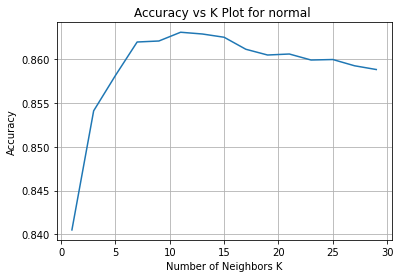

Accuracy scores for each K value is :  [0.841 0.854 0.858 0.862 0.862 0.863 0.863 0.863 0.861 0.86  0.861 0.86
 0.86  0.859 0.859]


In [37]:
# plotting accuracy vs K
plt.plot(neighbors, cv_scores)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K Plot for normal ")
plt.grid()
plt.show()

print("Accuracy scores for each K value is : ", np.round(cv_scores, 3))

### Brute Force using Time Based

In [38]:
# Time based splits
tscv = TimeSeriesSplit(n_splits = 10)

# creating a list of K's for performing KNN
my_list = list(range(0,30))

# filtering out only the odd K values
neighbors = list(filter(lambda x: x % 2 != 0, my_list))

# list to hold the cv scores
cv_scores = []

# perform 10-fold cross validation with default weights
for k in neighbors:
  Knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
  scores = cross_val_score(Knn, X_train_vector, Y_train, cv=tscv, scoring='accuracy', n_jobs = -1)
  cv_scores.append(scores.mean())

# finding the optimal k
time_optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print("The optimal K value is with default weight parameter: ", time_optimal_k)

The optimal K value is with default weight parameter:  7


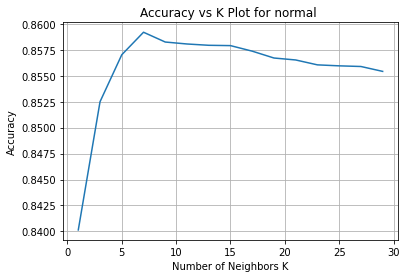

Accuracy scores for each K value is :  [0.84  0.852 0.857 0.859 0.858 0.858 0.858 0.858 0.857 0.857 0.857 0.856
 0.856 0.856 0.855]


In [39]:
# plotting accuracy vs K for time based split
plt.plot(neighbors, cv_scores)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K Plot for normal ")
plt.grid()
plt.show()

print("Accuracy scores for each K value is : ", np.round(cv_scores, 3))

In [40]:
# Finding the accuracy of KNN with optimal K (Normal split)

from sklearn.metrics import accuracy_score

# create object of classifier
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k, algorithm = 'brute', 
                                   n_jobs = -1)

# fit the model
knn_optimal.fit(X_train_vector,Y_train)

# predict on test vector
y_pred = knn_optimal.predict(X_test_vector)

# evaluate accuracy score
accuracy = accuracy_score(Y_test, y_pred)*100
print(f"The accuracy on test set using KNN for optimal K = {optimal_k} is {np.round(accuracy, 3)}%")

The accuracy on test set using KNN for optimal K = 11 is 86.273%


### Confusion Matrix for BoW Brute

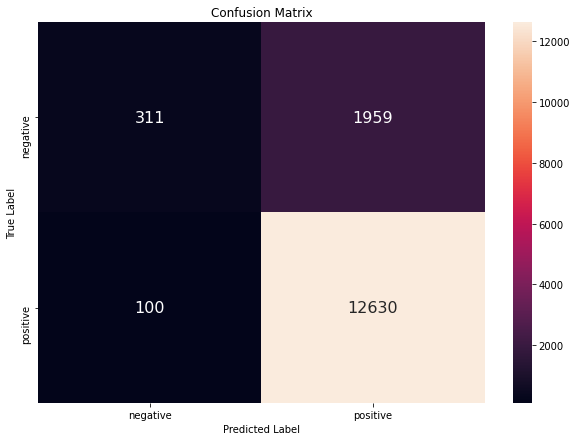

In [41]:
from sklearn.metrics import confusion_matrix

# for creating confusion matrix heatmap
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred), 
                        index = ["negative", 
                                "positive"], 
                        columns= ["negative", "positive"])
fig = plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
# More Metrics 

from sklearn.metrics import precision_score, recall_score, f1_score

# precision 
precision = precision_score(Y_test, y_pred, pos_label = 'positive')
print(f"The precision on test set using KNN for optimal K = {optimal_k} is {np.round(precision, 3)*100}%")


# recall
recall = recall_score(Y_test, y_pred, pos_label = 'positive')
print(f"The recall on test set using KNN for optimal K = {optimal_k} is {np.round(recall, 3)*100}%")


# f1 score
f1 = f1_score(Y_test, y_pred, pos_label='positive', average = 'weighted')
print(f"The f1_score on test set using KNN for optimal K = {optimal_k} is {np.round(f1, 3)*100}%")

The precision on test set using KNN for optimal K = 11 is 86.6%
The recall on test set using KNN for optimal K = 11 is 99.2%
The f1_score on test set using KNN for optimal K = 11 is 82.0%


Text(0.5, 1.0, '2-class Precision-Recall curve: P=0.87')

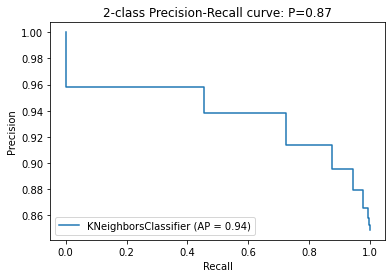

In [43]:
# plotting the precision and recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(knn_optimal, X_test_vector, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'P={0:0.2f}'.format(precision))

In [44]:
# Calculating auc_roc score

from sklearn.metrics import roc_curve, auc

# binarizing the classes as roc_curve function won't work on string
new_Y_test = np.where(Y_test == 'positive', 1, 0)
new_Y_pred = np.where(y_pred == 'positive', 1, 0)

# returns false positive rate, True positive rate and thresholds
fpr, tpr, thresholds = roc_curve(new_Y_test, new_Y_pred, pos_label=1)

# calculate auc
auc_roc = auc(fpr, tpr)

auc_roc

0.5645744728709801

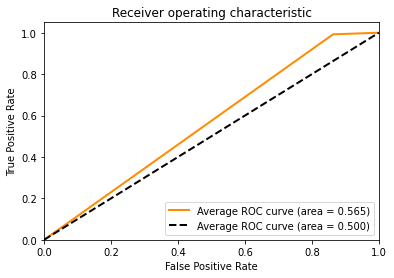

In [46]:
# plotting the ROC graph

plt.figure()
lw=2

plt.plot(fpr, tpr, color='darkorange', lw=lw, 
         label='Average ROC curve (area = {0:0.3f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', 
         label= 'Average ROC curve (area = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### KD Tree Implementation

In [47]:
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

svd = TruncatedSVD(n_components = 100)
X_train_vector_dense = svd.fit_transform(X_train_vector)
X_test_vector_dense = svd.transform(X_test_vector)

# creating a list of K's for performing KNN
my_list = list(range(0,50))

# filtering out only the odd K values
neighbors = list(filter(lambda x: x % 2 != 0, my_list))

# list to hold the cv scores
cv_scores = []

# perform 3-fold cross validation with default weights
for k in neighbors:
  Knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'kd_tree')
  scores = cross_val_score(Knn, X_train_vector_dense, Y_train, cv = 3, scoring='accuracy', n_jobs = -1)
  cv_scores.append(scores.mean())

# finding the optimal k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print("The optimal K value is with default weight parameter: ", optimal_k)

The optimal K value is with default weight parameter:  47


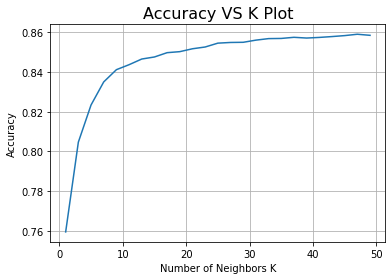


 Accuracy for each k value is :  [0.759 0.805 0.823 0.835 0.841 0.844 0.847 0.848 0.85  0.85  0.852 0.853
 0.855 0.855 0.855 0.856 0.857 0.857 0.858 0.857 0.857 0.858 0.858 0.859
 0.859]


In [48]:
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [49]:
 # Finding the accuracy of KNN with optimal K (Normal split)

from sklearn.metrics import accuracy_score

# create an instance of the model with optimal k
knn_optimal = KNeighborsClassifier(n_neighbors = 49, algorithm ='kd_tree', n_jobs = -1)

# fitting the model
knn_optimal.fit(X_train_vector_dense, Y_train)

# predict the scores
y_pred = knn_optimal.predict(X_test_vector_dense)

# evaluate accuracy score
accuracy = accuracy_score(Y_test, y_pred)*100
print(f"The accuracy on test set using KNN for optimal K = {optimal_k} is {np.round(accuracy, 3)}%")

The accuracy on test set using KNN for optimal K = 47 is 85.547%


In [50]:
knn_optimal = KNeighborsClassifier(n_neighbors = 39, algorithm ='kd_tree', n_jobs = -1)

# fitting the model
knn_optimal.fit(X_train_vector_dense, Y_train)

# predict the scores
y_pred = knn_optimal.predict(X_test_vector_dense)

# evaluate accuracy score
accuracy = accuracy_score(Y_test, y_pred)*100
print(f"The accuracy on test set using KNN for optimal K = 39 is {np.round(accuracy, 3)}%")

The accuracy on test set using KNN for optimal K = 39 is 85.553%


### Confusion Matrix for BoW KD Tree

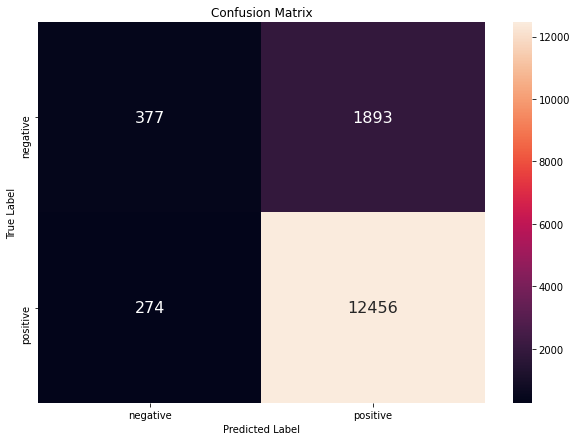

In [51]:
# for creating confusion matrix heatmap
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred), 
                        index = ["negative", 
                                "positive"], 
                        columns= ["negative", "positive"])
fig = plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [52]:
# More metrics

# precision 
precision = precision_score(Y_test, y_pred, pos_label = 'positive')
print(f"The precision on test set using KNN for optimal K = {optimal_k} is {np.round(precision, 3)*100}%")


# recall
recall = recall_score(Y_test, y_pred, pos_label = 'positive')
print(f"The recall on test set using KNN for optimal K = {optimal_k} is {np.round(recall, 3)*100}%")


# f1 score
f1 = f1_score(Y_test, y_pred, pos_label='positive', average = 'weighted')
print(f"The f1_score on test set using KNN for optimal K = {optimal_k} is {np.round(f1, 3)*100}%")

The precision on test set using KNN for optimal K = 47 is 86.8%
The recall on test set using KNN for optimal K = 47 is 97.8%
The f1_score on test set using KNN for optimal K = 47 is 82.0%


In [53]:
# Calculating auc_roc score

from sklearn.metrics import roc_curve, auc

# binarizing the classes as roc_curve function won't work on string
new_Y_test = np.where(Y_test == 'positive', 1, 0)
new_Y_pred = np.where(y_pred == 'positive', 1, 0)

# returns false positive rate, True positive rate and thresholds
fpr, tpr, thresholds = roc_curve(new_Y_test, new_Y_pred, pos_label=1)

# calculate auc
auc_roc = auc(fpr, tpr)

auc_roc

0.5722776680012874

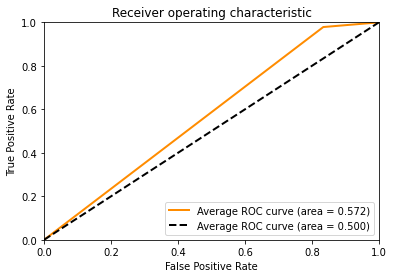

In [54]:
# plotting the ROC graph

plt.figure()

lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, 
         label='Average ROC curve (area = {0:0.3f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', 
         label= 'Average ROC curve (area = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Conclusion

**Brute Force Algorithm:** 

*   Optimal K : 11
*   Train Accuracy : 86.30%
*   Test Accuracy : 86.273%
*   Precision : 86.6%
*   Recall : 99.2%
*   f1-score : 82.0%
*   AUC score : 0.564

**KD Tree Algorithm:**

*   Optimal K : 49
*   Train Accuracy : 85.8%
*   Test Accuracy : 85.587%
*   Precision : 86.7%
*   Recall : 98.1%
*   f1-score : 81.8%
*   AUC score : 0.568
